The analysis so far has shown that the most important region is 'Others' as it accounts for over 99% of boths deaths and cases. With this in mind the focus of the following time-series analysis on new cases and vaccinations will be focused on the 'Others' province.

In [26]:
# Import libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,9)})
import datetime as dt

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


%matplotlib inline

# Get multiple outputs in the same cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
 

# Import the CSV file with Pandas and convert 'Date' to datetime
cov = pd.read_csv("covid_19_uk_cases.csv", index_col=['Date'], parse_dates=['Date'])
vac = pd.read_csv("covid_19_uk_vaccinated.csv", index_col=['Date'], parse_dates=['Date'])

# Drop columns not useful for the analysis
cov = cov.drop(['Lat','Long','ISO 3166-1 Alpha 3-Codes','Sub-region Name',
                'Intermediate Region Code','Recovered','Hospitalised'], axis=1)
vac = vac.drop(['Lat','Long','ISO 3166-1 Alpha 3-Codes','Sub-region Name',
                'Intermediate Region Code'], axis=1)

# Join the DataFrames as covid where you merge cov and vac
final_table = pd.merge(cov, vac, on=['Date','Province/State','Country/Region'], how='left')

# Ratio of people who have taken both the first and second dose thus fully vaccinated
final_table['Two Doses'] = (final_table ['Second Dose'] * 
                                       100) / final_table['First Dose']
# Ratio of people who have only taken the first dose
final_table['One Dose'] = (final_table['First Dose'] - final_table['Second Dose'])* 100 / final_table['First Dose']

# Replace NaN values with 0
final_table.fillna(0, inplace=True)

In [27]:
# a) Create a new cases column in the DataFrame

# create a temp table for the new cases 
temp = final_table.groupby(['Province/State', 'Date', ])[['Cases']]
temp = temp.sum().diff().reset_index()
temp.loc['Cases'] = np.nan

# renaming columns
temp.columns = ['Province/State', 'Date', 'New_cases']

# merging new values
final_table = pd.merge(final_table, temp, on=['Province/State', 'Date'])

# filling na with 0
final_table = final_table.fillna(0)

# fixing data types
cols = ['New_cases']
final_table[cols] = final_table[cols].astype('int')

# loop to replace negative values
final_table['New_cases'] = final_table['New_cases'].apply(lambda x: 0 if x<0 else x)

# b) calculate the growth rate and store in a new column
final_table['Growth_rate'] = (final_table['New_cases'] / final_table['Cases']) *100

# filling na with 0
final_table['Growth_rate'].fillna(0, inplace=True)

# change index to date column
final_table.index = final_table['Date']

#Drop extra date column 
final_table.drop(['Date'], axis = 1, inplace=True)


final_table.head()


,Province/State,Country/Region,Deaths,Cases,Vaccinated,First Dose,Second Dose,Two Doses,One Dose,New_cases,Growth_rate
Date,,,,,,,,,,,
2020-01-22,Anguilla,United Kingdom,0.0,0.0,0,0,0,0.0,0.0,0,0.0
2020-01-23,Anguilla,United Kingdom,0.0,0.0,0,0,0,0.0,0.0,0,0.0
2020-01-24,Anguilla,United Kingdom,0.0,0.0,0,0,0,0.0,0.0,0,0.0
2020-01-25,Anguilla,United Kingdom,0.0,0.0,0,0,0,0.0,0.0,0,0.0
2020-01-26,Anguilla,United Kingdom,0.0,0.0,0,0,0,0.0,0.0,0,0.0



The analysis so far has shown that the most important region is 'Others' as it accounts for over 99% of boths deaths and cases. With this in mind the focus of the following time-series analysis on new cases and vaccinations will be focused on the 'Others' province.


#### The following cells will:

a) Create a subset of the data for 'Others' to use in the analysis

b) Plot a histogram of the distrubiton of daily cases

c) Detect and remove outliers and use a boxplot to show the range

d) Resample the DataFrame to months

e) Use provided provided function for moving averages and plot the timeseries for new cases using 1  month and 3 months moving averages.

In [28]:
# Create subset
df_1 = final_table[final_table['Province/State']=='Others']

(array([351.,  45.,  52.,  55.,  54.,  45.,  12.,   8.,   8.,   2.]),
 array([    0. ,  6805.3, 13610.6, 20415.9, 27221.2, 34026.5, 40831.8,
        47637.1, 54442.4, 61247.7, 68053. ]),
 <BarContainer object of 10 artists>)

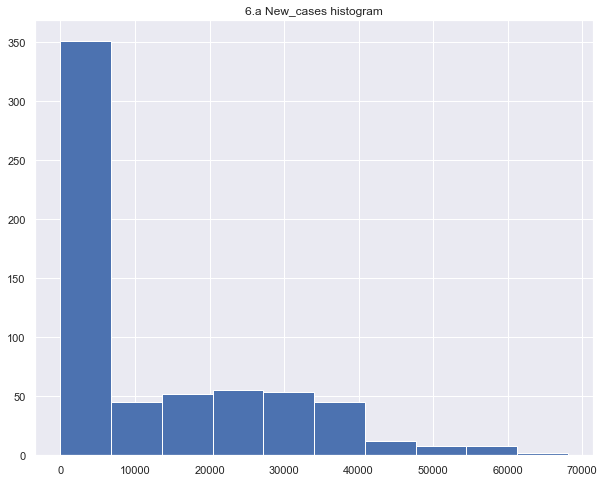

In [44]:
# Plot histogram
fig, axes = plt.subplots(figsize=(10,8))

axes.hist(df_1['New_cases'])
axes.title.set_text('6.a New_cases histogram')

In [39]:
# The columns you want to search for outliers in.
cols = ['New_cases'] 

# Calculate quantiles and IQR.
# Same as np.percentile but maps (0,1) and not (0,100).
Q1 = df_1[cols].quantile(0.25) 
Q3 = df_1[cols].quantile(0.75)
IQR = Q3 - Q1
IQR

# Return a Boolean array of the rows with (any) non-outlier column values.
condition = ~((df_1[cols] < (Q1 - 1.5 * IQR)) | (df_1[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our DataFrame based on condition.
df_1_non_outlier = df_1[condition]
df_1_non_outlier.shape


New_cases    21771.75
dtype: float64

(626, 11)

Text(0.5, 1.0, '6.b New_cases boxplot')

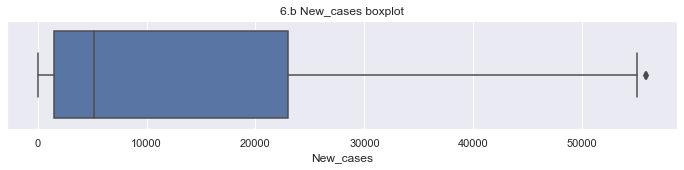

In [52]:
# Plot to see if outliers have been removed: 
# whis=multiplicative factor.
fig = plt.subplots(figsize=(12, 2))

ax = sns.boxplot(x=df_1_non_outlier['New_cases'],whis=1.5)
ax.set_title("6.b New_cases boxplot", fontsize=12)

In [41]:
# Resample the data set with 1 bedroom.
df_1_res = df_1_non_outlier.resample('M').mean()
df_1_res.head()
# Drop the missing values: 
df_1_res.dropna(inplace= True)
df_1_res.isna().sum()


,Deaths,Cases,Vaccinated,First Dose,Second Dose,Two Doses,One Dose,New_cases,Growth_rate
Date,,,,,,,,,
2020-01-31,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.200000,10.000000
2020-02-29,0.000000,20.896552,0.0,0.0,0.0,0.0,0.0,2.034483,9.034851
2020-03-31,404.838710,9071.322581,0.0,0.0,0.0,0.0,0.0,1239.451613,18.480283
2020-04-30,15208.066667,109999.133333,0.0,0.0,0.0,0.0,0.0,4635.300000,4.940373
2020-05-31,33171.322581,225037.322581,0.0,0.0,0.0,0.0,0.0,2535.548387,1.174006


Deaths         0
Cases          0
Vaccinated     0
First Dose     0
Second Dose    0
Two Doses      0
One Dose       0
New_cases      0
Growth_rate    0
dtype: int64

In [35]:
# Function to calculate and plot the simple moving average: 
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(12,4))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Simple moving average trend')
    
 # Plot confidence intervals for smoothed values.
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

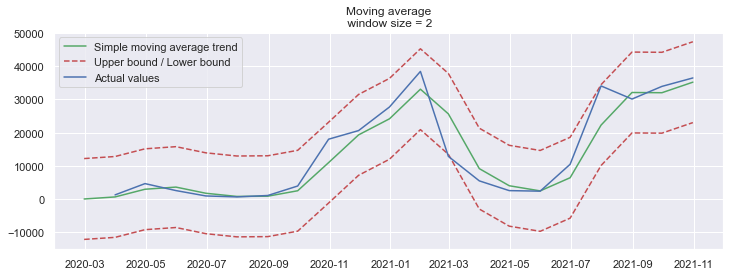

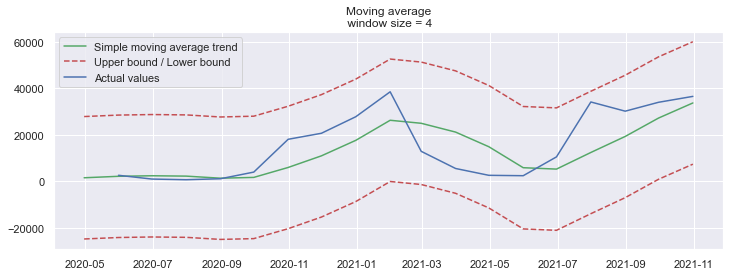

In [38]:
# 1 Month
plot_moving_average(df_1_res.New_cases, 2, plot_intervals=True)

# 3 Months
plot_moving_average(df_1_res.New_cases, 4, plot_intervals=True)



#### Observation

Both the 1 Month and 3 Months moving averages are in an uptrend. The moving averages lag behind the actual figures and as these are also in an uptrend we can confidently predict that average will continue to rise into the near future.


In [47]:
# create subset
df_2 = final_table[final_table['Province/State']=='Others']

(array([442.,  29.,  40.,  48.,  19.,  11.,  12.,  17.,  12.,   2.]),
 array([    0. ,  3063.2,  6126.4,  9189.6, 12252.8, 15316. , 18379.2,
        21442.4, 24505.6, 27568.8, 30632. ]),
 <BarContainer object of 10 artists>)

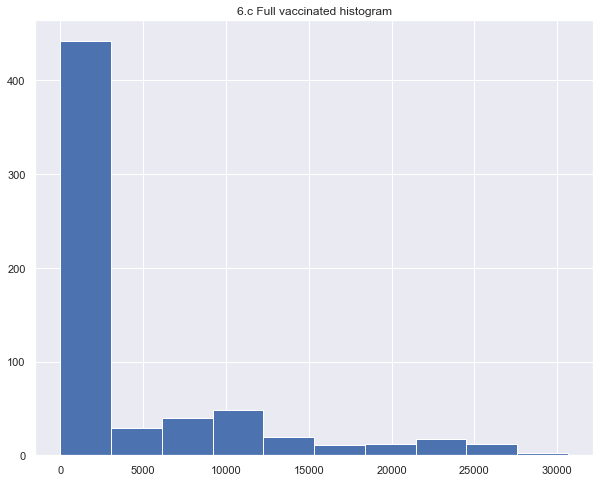

In [48]:
# Plot histogram
fig, axes = plt.subplots(figsize=(10,8))


axes.hist(df_2['Vaccinated'])
axes.title.set_text('6.c Full vaccinated histogram')

In [49]:
# Remove outliers
# The columns you want to search for outliers in.
cols = ['Vaccinated'] 

# Calculate quantiles and IQR.
# Same as np.percentile but maps (0,1) and not (0,100).
Q1 = df_2[cols].quantile(0.25) 
Q3 = df_2[cols].quantile(0.75)
IQR = Q3 - Q1
IQR

# Return a Boolean array of the rows with (any) non-outlier column values.
condition = ~((df_2[cols] < (Q1 - 1.5 * IQR)) | (df_2[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our DataFrame based on condition.
df_2_non_outlier = df_2[condition]
df_2_non_outlier.shape

Vaccinated    6421.25
dtype: float64

(579, 11)

Text(0.5, 1.0, '6.d Vaccinated boxplot')

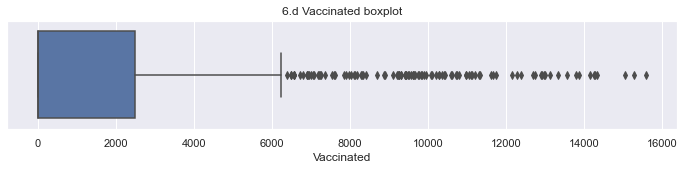

In [51]:
# Plot to see if outliers have been removed: 
fig = plt.subplots(figsize=(12, 2))

ax = sns.boxplot(x=df_2_non_outlier['Vaccinated'],whis=1.5)
ax.set_title("6.d Vaccinated boxplot", fontsize=12)

In [53]:
# Resample the data set with 1 bedroom.
df_1_res = df_1_non_outlier.resample('M').mean()
df_1_res.head()
# Drop the missing values: 
df_1_res.dropna(inplace= True)
df_1_res.isna().sum()


,Deaths,Cases,Vaccinated,First Dose,Second Dose,Two Doses,One Dose,New_cases,Growth_rate
Date,,,,,,,,,
2020-01-31,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.200000,10.000000
2020-02-29,0.000000,20.896552,0.0,0.0,0.0,0.0,0.0,2.034483,9.034851
2020-03-31,404.838710,9071.322581,0.0,0.0,0.0,0.0,0.0,1239.451613,18.480283
2020-04-30,15208.066667,109999.133333,0.0,0.0,0.0,0.0,0.0,4635.300000,4.940373
2020-05-31,33171.322581,225037.322581,0.0,0.0,0.0,0.0,0.0,2535.548387,1.174006


Deaths         0
Cases          0
Vaccinated     0
First Dose     0
Second Dose    0
Two Doses      0
One Dose       0
New_cases      0
Growth_rate    0
dtype: int64

In [55]:
# Function to calculate and plot the simple moving average: 
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(12,4))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Simple moving average trend')
    
 # Plot confidence intervals for smoothed values.
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

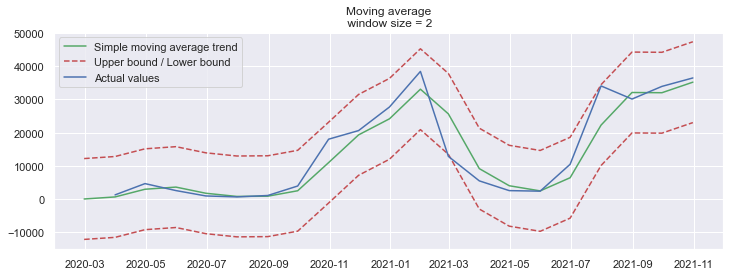

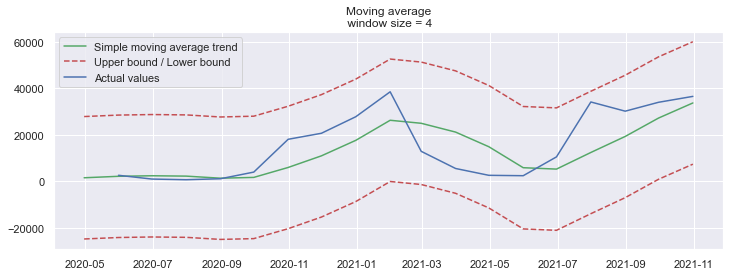

In [56]:
# 1 Month
plot_moving_average(df_1_res.New_cases, 2, plot_intervals=True)

# 3 Months
plot_moving_average(df_1_res.New_cases, 4, plot_intervals=True)
